In [ ]:
from tensorflow.python.eager.context import num_gpus
from tensorflow.python.keras.engine.compile_utils import LossesContainer
from tensorflow.python.keras.layers.convolutional import Conv
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import numpy as np
from random import shuffle
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Conv2D, Bidirectional, Dense, MaxPooling2D, MaxPooling3D, Reshape, Flatten, TimeDistributed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import CategoricalCrossentropy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Global Variables
IMG_SIZE = 100
OPTIMIZER = 'SGD'
LEARNING_RATE = 0.01
DECAY = 1e-6
EPOCHS = 25
BATCH_SIZE = 5
LOSS = CategoricalCrossentropy()
NUM_FRAMES = 10
KERNEL = 64

In [ ]:

OUTPUTFILEPATH ="./HockeyDataset/"

violenceIndicator ='fi'
nonViolenceIndicator = 'no'

if not os.path.exists(OUTPUTFILEPATH):
    os.mkdir(OUTPUTFILEPATH)



In [ ]:
#Video Frame Extraction
def extractFrames(folder):

    if os.path.exists(folder) == False:
        print(str(folder) + " not found")
        return;

    c =0
    for files in tqdm(os.listdir(folder)):
        path = os.path.join(folder, files)
        cap = cv2.VideoCapture(path)

        success = True

        while success:
            success, image = cap.read()

            # RGB_img =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            RGB_img = image

            if not success:
                break

            if (violenceIndicator in files):
                if not os.path.exists(OUTPUTFILEPATH + "/" + violenceIndicator):
                    os.mkdir(OUTPUTFILEPATH + "/" + violenceIndicator +"/")

                cv2.resize(cv2.imwrite(OUTPUTFILEPATH + "/" + violenceIndicator+ "/"+ str(c) + '.jpg', RGB_img), (IMG_SIZE, IMG_SIZE))
            else:
                if not os.path.exists(OUTPUTFILEPATH + "/" + nonViolenceIndicator):
                    os.mkdir(OUTPUTFILEPATH + "/" + nonViolenceIndicator +"/")
                    
                cv2.resize(cv2.imwrite(OUTPUTFILEPATH + "/" + nonViolenceIndicator+ "/"+ str(c) + '.jpg', RGB_img), (IMG_SIZE, IMG_SIZE))

            c +=1
    print(c)
    print("Done with file extraction")


In [ ]:
#dataset generation
def GenerateDataset():
    dataset = []
    images = []
    limit = 0
    
    violenceFilePath = OUTPUTFILEPATH + violenceIndicator +"/"
    nonViolenceFilePath = OUTPUTFILEPATH + nonViolenceIndicator + "/"

    for frames in tqdm(os.listdir(violenceFilePath)):
        path = os.path.join(violenceFilePath, frames)
        img = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))

        images.append(np.array(img))
        limit +=1
    

        if limit == NUM_FRAMES:
            limit = 0
            dataset.append(np.array([images, np.array([0, 1])]))
            images = []

    for frames in tqdm(os.listdir(nonViolenceFilePath)):
        path = os.path.join(nonViolenceFilePath, frames)
        img = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))

        images.append(np.array(img))
        limit +=1
    

        if limit == NUM_FRAMES:
            limit = 0
            dataset.append(np.array([images, np.array([1, 0])]))
            images = []


    print("Dataset Count " + str(len(dataset)))
    shuffle(dataset)
    np.save('datasetCNN.npy', dataset)
    return dataset

In [ ]:
#Assign Extracted Data

#__Extract frames from data____
extractFrames("./drive/MyDrive/HockeyFights")

data = GenerateDataset()

#Uncomment if data has been extracted
#data = np.load('datasetCNN.npy', allow_pickle=True)

#print(data)

100%|██████████| 1012/1012 [10:10<00:00,  1.66it/s]


41548
Done with file extraction


100%|██████████| 20622/20622 [00:31<00:00, 660.21it/s]


Dataset Count 4154


In [ ]:

train, test = train_test_split(data, train_size=0.7, shuffle=True)

# print(train[0][1])
# print(train[1][1])


X = np.array([i[0] for i in train]).reshape(-1, NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in train])

x_valid = np.array([i[0] for i in test]).reshape(-1, NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)
y_valid = np.array([i[1] for i in test])

X = X.astype('float32')
x_valid = x_valid.astype('float32')

X /= 255
x_valid /=255

#print(X)
print("Training sample size = " +str(len(X)))
print("Testing sample size = " +str(len(x_valid)))
print(x_valid.shape)
print(y[0])
print(len(y))


Training sample size = 2907
Testing sample size = 1247
(1247, 10, 100, 100, 3)
[0 1]
2907


In [ ]:
print(X[1].shape);

(10, 100, 100, 3)


[1 0]
<built-in function array>


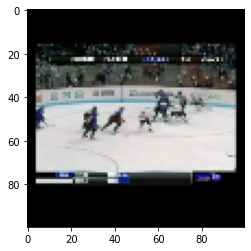

In [ ]:
num = 111
visible_frame = X[num]
visible_frame =  np.array(visible_frame).reshape(10,100,100,3)

plt.imshow(visible_frame[7])
print(y[num])
print(np.array)


In [ ]:
#Architecture of Model

model = Sequential()
#input
model.add(Conv2D(KERNEL, (3, 3), activation='relu',  input_shape = (NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3), padding ='same'))

#____v_____
model.add(Conv2D(KERNEL, (3, 3), activation='relu'))
model.add(MaxPooling3D((1,2,2)))
model.add(Dropout(0.25))

#____v_____
model.add(Conv2D(KERNEL, (3, 3), activation='relu'))
model.add(MaxPooling3D((1,2,2)))
model.add(Dropout(0.25))

#____v_____
model.add(Conv2D(KERNEL, (3, 3), activation='relu'))
model.add(MaxPooling3D((1,2,2)))
model.add(Dropout(0.25))

#___V____
model.add(Flatten())
#model.add(Reshape((NUM_FRAMES, KERNEL * IMG_SIZE)));

#________V_________
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(2, activation='softmax'))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss= LOSS, optimizer= SGD(LEARNING_RATE), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 100, 100, 64)  1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 98, 98, 64)    36928     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 49, 49, 64)    0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 49, 49, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 47, 47, 64)    36928     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 23, 23, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 23, 23, 64)    0

In [ ]:
#Model Training
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs= EPOCHS, verbose=1, validation_data=(x_valid,y_valid))

score = model.evaluate(x_valid, y_valid, verbose =0)
print('Test loss', score[0])
print('Test accuracy', score[1])

Epoch 1/25
582/582 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8074

In [ ]:
history_dict = history.history;

loss_value = history_dict['loss'];
val_loss_value = history_dict['val_loss'];
epoch = range(1,len(loss_value) + 1);

line1 =plt.plot(epoch, val_loss_value, label="Validation/Test loss");
line2 =plt.plot(epoch, loss_value, label="Training loss");

plt.setp(line1, linewidth=2.0, marker ='+', markersize = 10.0);
plt.setp(line2, linewidth=2.0, marker ='4', markersize = 10.0);

plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.grid(True);
plt.legend()

plt.show();

In [ ]:
history_dict = history.history;

acc_value = history_dict['accuracy'];
val_acc_value = history_dict['val_accuracy'];
epoch = range(1,len(acc_value) + 1);

line1 =plt.plot(epoch, val_acc_value, label="Validation/Test accuracy");
line2 =plt.plot(epoch, acc_value, label="Training accuracy");

plt.setp(line1, linewidth=2.0, marker ='+', markersize = 10.0);
plt.setp(line2, linewidth=2.0, marker ='4', markersize = 10.0);

plt.xlabel('Epochs');
plt.ylabel('Accuracy');
plt.grid(True);
plt.legend()

plt.show();


In [ ]:
model.save("SavedFirst/SavedFirst.h5");
print("Saved Model");

In [ ]:
classifier = load_model("SavedFirst/SavedFirst.h5")

classifier.summary()

score = classifier.evaluate(x_valid, y_valid, verbose =0)
print(y_valid)
print('Test loss', score[0])
print('Test accuracy', score[1])

In [ ]:
def showModelTest(input_value, prediction):
  print("Prediction= ")
  print(prediction)
  plt.imshow(input_value)

In [ ]:
rand = np.random.randint(0, len(x_valid))
input_v = x_valid[rand]
print(input_v.shape)

input_v = input_v[0].reshape(100,100,3)

print(x_valid[rand].shape)
print(x_valid.shape);
val = x_valid[rand].reshape(1,10,100,100,3)

result = classifier.predict_classes(val, 1,  verbose = 0)

print(result)

showModelTest(input_v, str(result))